# Basics of Analytical Backpropagation

The following exercise is an introduction to back-propagation (one of the cornerstones of ML!), and at the same time a gentle introduction to PyTorch, which can do this analytically.

You should read/run the code until you reach (and do) Exercise 1 in this notebook, then move on to CNN exercise.
Come back later if you want to do the rest.

<sup>Author: Julius B. Kirkegaard, May 2022</sup>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

## Numpy vs Torch

We will be using PyTorch, which for most operations works just like numpy. You can also easily swap between the two.

Let's see some examples:

In [2]:
np.arange(10), torch.arange(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [3]:
np.arange(10, dtype=np.double), torch.arange(10, dtype=torch.double)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64))

In [4]:
x = torch.arange(10, dtype=torch.double)

In [5]:
x*x + 2

tensor([ 2.,  3.,  6., 11., 18., 27., 38., 51., 66., 83.], dtype=torch.float64)

In [6]:
torch.sin(x)

tensor([ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
         0.9894,  0.4121], dtype=torch.float64)

You can, for most parts, also use PyTorch tensors, whereever you would use a numpy array.
 For example:

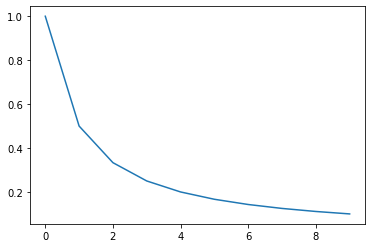

In [7]:
plt.plot(x, 1/(1 + x));

And you can swap between them:

In [8]:
x.numpy()

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [9]:
torch.from_numpy(np.arange(10))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The big difference is between the two is that PyTorch allows analytical differentiation and can work on GPUs. This is what you will learn about in this exercise.

## Numerical differentiation

Let's define some function of `x`. Feel free to change it to whatever you want.

In [10]:
def f(x):
    return x**2

This one is easy enough to differentiate by hand:

In [11]:
def f_prime(x):
    return 2 * x

We can also do it numerically:

In [12]:
def f_prime_numerical(x, dx=0.01):
    return (f(x + dx) - f(x)) / dx

Let's try it out:

In [13]:
f(x)

tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.], dtype=torch.float64)

In [14]:
f_prime(x)

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.], dtype=torch.float64)

In [15]:
f_prime_numerical(x)

tensor([1.0000e-02, 2.0100e+00, 4.0100e+00, 6.0100e+00, 8.0100e+00, 1.0010e+01,
        1.2010e+01, 1.4010e+01, 1.6010e+01, 1.8010e+01], dtype=torch.float64)

Our numerical scheme is okay, but doesn't quite get the right answer. We could try a lower `dx`:

In [16]:
f_prime_numerical(x, dx=0.0001)

tensor([1.0000e-04, 2.0001e+00, 4.0001e+00, 6.0001e+00, 8.0001e+00, 1.0000e+01,
        1.2000e+01, 1.4000e+01, 1.6000e+01, 1.8000e+01], dtype=torch.float64)

Better, but not perfect.

## Analytical differentiation

PyTorch knows how to differentiate functions. To do so, it needs to know which paramters you want to differentiate with respect to. You tell torch this by defining these paramters as "requiring gradients".

Let's tell torch that we require gradients with respect to some paramter `x`:

In [17]:
x = torch.arange(10, dtype=torch.double, requires_grad=True)

What we want to calculate is `df/dx` at `x[0]`, `x[1]`, `x[2]`, etc... But it is only simple to differentiate scalars in torch. The trick that one can use over and over again, is to form a sum `S = f(x[0]) + f(x[1]) + ... f(x[N])` and differentiate this sum with respect to `x`.

The notation is a bit weird, but here is how to do it:

In [18]:
S = torch.sum(f(x))  # Form the sum

In [19]:
S.backward()  # differentiate with respect to all parameters marked as as "requires_grad".

In [20]:
x.grad  # Here you will find dS/dx

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.], dtype=torch.float64)

As you can see the differentiation is perfect, even though the notation is really weird.
Once done, you need to clear the gradients to calculate new ones:

In [21]:
x.grad.zero_();

To get you familiar with the idea we will show a few more examples. Check by hand that they are correct:

##### Example 

In [22]:
fx = x**3

In [23]:
S = torch.sum(fx)

In [24]:
S.backward()

In [25]:
x.grad

tensor([  0.,   3.,  12.,  27.,  48.,  75., 108., 147., 192., 243.],
       dtype=torch.float64)

In [26]:
x.grad.zero_();

##### Example 

In [27]:
fx = torch.sin(x) * torch.cos(x**2)

In [28]:
S = torch.sum(fx)

In [29]:
S.backward()

In [30]:
x.grad

tensor([  1.0000,  -1.1242,   3.0246,   0.5531,  -1.1171,  -0.9880,  -3.4483,
          8.9991, -14.6208,   3.9649], dtype=torch.float64)

In [31]:
x.grad.zero_();

### Exercise 1: Two Parameters

Try the above, but on the function `f(x) = x**2 * y**3`. Note that both `x` and `y` needs to require gradients. Make sure you understand the output of `x.grad` and `y.grad`.

<sub>Hint: remember to zero their gradients before every gradient calculation.</sub>

## When to require gradients

Some operations are not allowed on tensors that `require_grad`. For instance, you cannot do in-place operations:

In [32]:
x = torch.linspace(0, 1, 10)
y = torch.linspace(0, 1, 10)
x.requires_grad = True

In [33]:
x + 2  # allowed

tensor([2.0000, 2.1111, 2.2222, 2.3333, 2.4444, 2.5556, 2.6667, 2.7778, 2.8889,
        3.0000], grad_fn=<AddBackward0>)

In [34]:
y + 2  # allowed

tensor([2.0000, 2.1111, 2.2222, 2.3333, 2.4444, 2.5556, 2.6667, 2.7778, 2.8889,
        3.0000])

In [35]:
y += 2 # allowed

In [36]:
x += 2 # not allowed

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

We can do such operations if we tell PyTorch that we do not need the gradients of this operation:

In [37]:
with torch.no_grad():
    x += 2

Alternatively, we can take `x` out of the calculational graph:

In [38]:
x = x.detach()
x += 2

But now `x` no longers has `require_grad = True`.

## Example usage: Fitting a Function

In [39]:
x = torch.linspace(-1, 1, 100, dtype=torch.double)

In [40]:
def f(x, a, b, c):
    return a*torch.exp(b*(c - x)**2)

In [41]:
y = f(x, a=2.3, b=1.5, c=0.15)  # we prenend we do not know these parameters

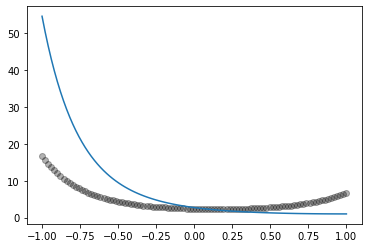

In [42]:
plt.plot(x, y, 'ko', alpha=0.3)
plt.plot(x, f(x, a=1.0, b=1.0, c=1.0)) # initial guess

### Differentiation and steepest descent


a=2.297, b=1.502, c=0.150


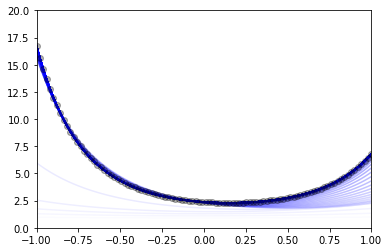

In [43]:
# Choose initial guess of paramters (remember to set them to require_grad)
a = torch.tensor(1.0, requires_grad=True, dtype=torch.double);
b = torch.tensor(1.0, requires_grad=True, dtype=torch.double);
c = torch.tensor(1.0, requires_grad=True, dtype=torch.double);

losses = []

step_size=1e-3
n_steps = 1500
steps = trange(n_steps)
for step in steps:
    fx = f(x, a, b, c)  # Evaluate the function with the current a, b, c
    loss = torch.mean((fx - y)**2)  # We the squared mean distance between the curves as a loss function
    steps.set_description(f'Loss = {loss:.2f}')
    losses.append(float(loss))
    loss.backward()  # Calculate gradients
    with torch.no_grad():  # Take steps:
        a -= a.grad * step_size 
        b -= b.grad * step_size
        c -= c.grad * step_size
    # Zero gradients again:
    a.grad.zero_()
    b.grad.zero_()
    c.grad.zero_()
    if step % 25 == 0:
        plt.plot(x, fx.detach(), 'b', alpha=step/n_steps) 

plt.plot(x, y, 'ko', alpha=0.3)
plt.axis([-1, 1, 0, 20])
print(f'a={a:.3f}, b={b:.3f}, c={c:.3f}')


### Exercise 3: counting function calls

In terms of computation, the call `.backward()` takes about the same amount of CPU time as a call to the function itself `f(x)`. So to calculate the gradients w.r.t. the paramters `a, b, c`, we have made "2" calls to f(x).

If instead you had to do the above method using numerical differentiation, how many function calls would be needed to `f(x)`?

What if you had `n` parameters?
And how many function calls with `n` parametes using the analytical approach?

### Exercise 4: perfecting the fit

In [44]:
print('Loss =', loss)

Loss = tensor(1.1796e-05, dtype=torch.float64, grad_fn=<MeanBackward0>)


Our loss got all the way down to 1e-5. That's pretty good. In this case, we would usually say "good enough". However, for instance in machine learning problems, this is not good enough. We want to get as low as possible.

Exercise: try playing with `step_size` and `steps`. How few `steps` can you get away with in order to push the the final `loss` below `1e-10`?

## Adam Optimizer

In the case where `f(x)` is expensive to evaluate, we want to get away with as few steps as possible. So let's try and improve the above.

First let's see how the loss evolved (we can do this, since we stored the `loss` after each iteration):

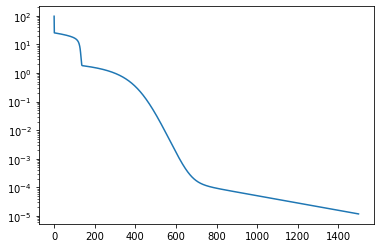

In [45]:
plt.semilogy(losses);

Clearly it went down really fast, but then became slower and slower. Why does this happen?

To counter this, we can move faster and faster as we progress.

Focusing on the paramter `a`, here is how we updated it:

```python
for step in ...
    g = a.grad
    with torch.no_grad():
        a -= g * step_size
    ...
```

A cool approach is one called "Adam". It works like this:

```python
m_a = 0
v_a = 0
for step in ...
    g = a.grad
    m_a = b1 * m_a + (1 - b1) * g
    v_a = b2 * v_a + (1 - b2) * g**2
    m_a_hat = m_a / (1 - b1**step)
    v_a_hat = v_a / (1 - b2**step)
    
    with torch.no_grad():
        a -= step_size * m_a_hat / (torch.sqrt(v_a_hat) + eps)
    ...
```

Here `b1, b2, eps` are paramters. Good values for these are `b1=0.9, b2=0.999, eps=1e-08`. With Adam, for this problem, you can get away with `step_size=0.1` as well.

### Exercise 4: Adam

Update the code to use the Adam method. How many `steps` can you now get away with in order to get the loss betlow 1e-10?

## PyTorch Optimizers

Finally, we will use PyTorch's built-in optimizers to do the same.
It's important do have done the above exercise, though, in order to understand the inner workings.
But this shows how great it is to know stuff like this built right into the library:

In [46]:
a = torch.tensor(1.0, requires_grad=True, dtype=torch.double);
b = torch.tensor(1.0, requires_grad=True, dtype=torch.double);
c = torch.tensor(1.0, requires_grad=True, dtype=torch.double);

losses = []

n_steps = 5000
steps = trange(n_steps)
step_size = 0.01
optimizer = torch.optim.Adam(params=[a, b, c], lr=step_size)
for step in steps:
    fx = f(x, a, b, c)
    loss = torch.mean((fx - y)**2)
    steps.set_description(f'Loss = {loss:.2f}')
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
print(f'a={a:.3f}, b={b:.3f}, c={c:.3f}')
print(f'Loss = {float(loss)}')


a=2.300, b=1.500, c=0.150
Loss = 6.290966945575681e-11
